<!-- LAB U-Net Model -->
<div class="alert" style="background: linear-gradient(to right, rgb(100,100,100), rgb(200,200,200)); color:white;">

# **U-NET LAB Colorization Model**
***
This notebook implements a U-Net model for image colorization using the LAB color space. The model takes grayscale images (L channel) as input and predicts the a* and b* color channels.

### Key Features:
- LAB color space for better color prediction
- Real-time visualization of colorization progress
- TensorBoard integration for detailed monitoring
- Combined loss function (0.84 MSE + 0.16 MAE)
- Batch normalization and dropout for stability

### Model Architecture:
- Input: Grayscale image (L channel)
- Output: a* and b* channels
- Encoder: 3 levels with increasing filters (64, 128, 256)
- Bottleneck: 512 filters with dropout
- Decoder: 3 levels with skip connections
</div>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import datetime
import sys

# Add Src directory to path for importing our model
sys.path.append('../Src')
from unet_model_lab import (
    build_unet_lab,
    lab_loss,
    get_callbacks,
    rgb_to_lab
)

## 1. Setup Directories

In [2]:
# Create directories for logs and models
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join('logs', 'lab_unet_' + timestamp)
model_dir = 'Models'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

print(f"Logs will be saved to: {log_dir}")
print(f"Models will be saved to: {model_dir}")

Logs will be saved to: logs\lab_unet_20250524-090641
Models will be saved to: Models


## 2. Load and Preprocess Data

In [3]:
print("Loading training data...")
X_train = np.load("../Data/prepared_data/comic_input_grayscale_train.npy")
y_train = np.load("../Data/prepared_data/comic_output_color_train.npy")
X_test = np.load("../Data/prepared_data/comic_input_grayscale_test.npy")
y_test = np.load("../Data/prepared_data/comic_output_color_test.npy")

print("\nData shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

Loading training data...

Data shapes:
X_train: (256, 256, 256, 1)
y_train: (256, 256, 256, 3)
X_test: (64, 256, 256, 1)
y_test: (64, 256, 256, 3)


## 3. Convert to LAB Color Space

In [4]:
print("Converting to LAB color space...")
y_train_lab = np.array([rgb_to_lab(img) for img in y_train])
y_test_lab = np.array([rgb_to_lab(img) for img in y_test])

# Extract a* and b* channels for training targets
y_train_ab = y_train_lab[:, :, :, 1:]  # Channels 1 and 2 are a* and b*
y_test_ab = y_test_lab[:, :, :, 1:]    # Channels 1 and 2 are a* and b*

# Normalize input images to [-1, 1] range
X_train = (X_train - 0.5) * 2
X_test = (X_test - 0.5) * 2

print("\nProcessed data shapes:")
print(f"X_train: {X_train.shape} (normalized to [-1, 1])")
print(f"y_train_ab: {y_train_ab.shape} (a* and b* channels)")
print(f"X_test: {X_test.shape} (normalized to [-1, 1])")
print(f"y_test_ab: {y_test_ab.shape} (a* and b* channels)")

Converting to LAB color space...

Processed data shapes:
X_train: (256, 256, 256, 1) (normalized to [-1, 1])
y_train_ab: (256, 256, 256, 2) (a* and b* channels)
X_test: (64, 256, 256, 1) (normalized to [-1, 1])
y_test_ab: (64, 256, 256, 2) (a* and b* channels)


## 4. Build and Compile Model

In [5]:
print("Building model...")
input_shape = (256, 256, 1)  # Grayscale input
model = build_unet_lab(input_shape)

# Plot model architecture
tf.keras.utils.plot_model(
    model, 
    to_file=os.path.join(log_dir, 'model_architecture.png'),
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True
)

# Display model summary
model.summary()

Building model...

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 8,567,682 (32.68 MB)

 Trainable params: 8,562,050 (32.66 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [6]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=lab_loss,
    metrics=['mae', 'mse']
)

## 5. Train Model

In [7]:
# Get callbacks
callbacks = get_callbacks(
    model_dir=model_dir,
    log_dir=log_dir,
    validation_data=(X_test, y_test)
)

# Train model
print(f"Starting training... Logs will be saved to {log_dir}")
history = model.fit(
    X_train, y_train_ab,
    validation_data=(X_test, y_test_ab),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Starting training... Logs will be saved to logs\lab_unet_20250524-090641
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step loss: 3921.4751 - mae: 60.0142 - mse: 4656.991
8/8 ━━━━━━━━━━━━━━━━━━━━ 179s 22s/step - loss: 3883.0251 - mae: 59.5544 - mse: 4611.3057 - val_loss: 257.3780 - val_mae: 11.1103 - val_mse: 304.2861 - learning_rate: 1.0000e-04
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 175s 22s/step - loss: 2288.3413 - mae: 40.8898 - mse: 2716.4270 - val_loss: 267.4393 - val_mae: 11.9604 - val_mse: 316.1020 - learning_rate: 1.0000e-04
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 180s 23s/step - loss: 1283.2688 - mae: 28.0506 - mse: 1522.3580 - val_loss: 2072.5410 - val_mae: 39.0208 - val_mse: 2459.8782 - learning_rate: 1.0000e-04
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 175s 22s/step - loss: 799.1600 - mae: 21.1419 - mse: 947.3541 - val_loss: 3583.8931 - val_mae: 52.1913 - val_mse: 4256.5986 - learning_rate: 1.0000e-04
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 174s 22s/step - loss: 550.8433 - mae: 17.4702 

## 6. Save Model and Training History

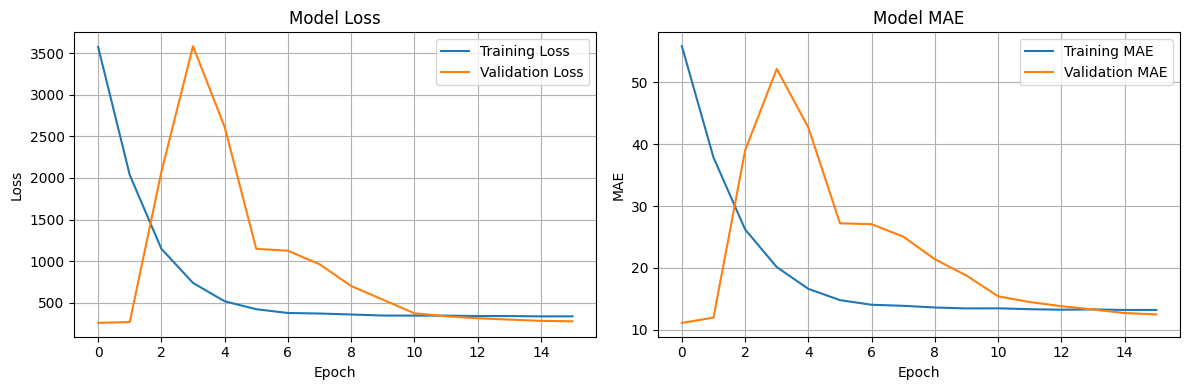

Training completed. Models and visualizations saved in Models and logs\lab_unet_20250524-090641


In [8]:
# Save final model
model.save(os.path.join(model_dir, "final_unet_lab.keras"))

# Plot and save training history
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(log_dir, 'training_history.png'))
plt.show()

print(f"Training completed. Models and visualizations saved in {model_dir} and {log_dir}")

In [9]:
%load_ext tensorboard
%tensorboard --logdir logs